In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from sklearn.metrics import mutual_info_score

import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
import lightgbm as lgb
import logging
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, ParameterGrid
import lightgbm as lgb
import numpy as np
import numpy as np


plant_power = {
    1: 10,
    2: 10,
    3: 40,
    4: 50
}


def mae_d(df_groupby, plant):
    pm = df_groupby['pm'].values
    pp = df_groupby['pp'].values
    threshold = plant_power[plant] * 0.03
    index = pm >= threshold
    return np.abs(pm[index] - pp[index]).sum() / (np.sum(index) * plant_power[plant])


def mae_m(df, plant):
    return df.groupby(df['datetime'].dt.day).apply(lambda x: mae_d(x, plant)).mean()


def score(df, plant):
    """

    :param df: datetime, pm, pp
    :param plant:
    :return:
    """
    month = df['datetime'].dt.month.unique()
    ret = []
    for m in month:
        ret.append(mae_m(df[df['datetime'].dt.month == m], plant))
    return np.mean(ret)


def score2(pm, pp, plant):
    threshold = plant_power[plant] * 0.03
    index = pm >= threshold
    return np.abs(pm[index] - pp[index]).sum() / (np.sum(index) * plant_power[plant])



def lgb_cv(params, x, y, metric, k=3, **kwargs):
    kf = KFold(k, **kwargs)
    weights = np.ones_like(y)
    weights[y > 0.03] = 5
    ret = []
    for train, valid in kf.split(x):
        train_set = lgb.Dataset(x[train], y[train], weight=weights[train], **kwargs)
        valid_set = lgb.Dataset(x[valid], y[valid], weight=weights[valid], **kwargs)
        mdl = lgb.train(params, train_set, valid_sets=[train_set, valid_set], verbose_eval=-1)
        ret.append(metric(y[valid], mdl.predict(x[valid])))
    return ret


def lgb_grid_search_cv(paras_grid, x, y, k=3, **kwargs):
    grid = list(ParameterGrid(paras_grid))
    max_score = np.inf
    best_param = None
    n_step = len(grid)
    for step, p in enumerate(grid):
        score = np.mean(lgb_cv(p, x, y, k=k, **kwargs))
        if score < max_score:
            best_param = p
            max_score = score
            print(f'step {step / n_step * 100: .1f}%, best cv score: {max_score: .4f}')
    return best_param, max_score

def load_dataset(plant):
    print(f'loading plant {plant} data')
    train = pd.read_csv(f'../data/train_{plant}.csv', parse_dates=["时间"]).drop_duplicates().reset_index(drop=True)
    test = pd.read_csv(f'../data/test_{plant}.csv', parse_dates=["时间"])
    train.columns = ['time', 'irr', 'ws', 'wd', 'temp', 'pr', 'hm', 'mirr', 'power']
    test.columns = ['id', 'time', 'irr', 'ws', 'wd', 'temp', 'pr', 'hm']
    data = pd.concat([train, test])
    return data


In [217]:
import numpy as np
from chinese_calendar import is_holiday


def arithmetic_mapping(f1, f2, df):
    ret = []
    features = []
    feature_cat = ['num'] * 4
    for act in '+-*/':
        ret.append(eval(f'df[f1] {act} df[f2]').values)
        features.append(f'{f1}{act}{f2}')
    ret = np.stack(ret, axis=1)
    return ret, features, feature_cat


def arithmetic_field_mapping(fields_1, fields_2, df):
    field_combination = [(f1, f2) for f1 in fields_1 for f2 in fields_2]
    ret, features, feature_cat = [], [], []
    for f1, f2 in field_combination:
        if f1 == f2:
            continue
        r, fs, fc = arithmetic_mapping(f1, f2, df)
        ret.append(r)
        features += fs
        feature_cat += fc
    return np.concatenate(ret, axis=1), features, feature_cat


def origin_feature(df):
    feature = df[['hm', 'irr', 'pr', 'temp', 'wd', 'ws']]
    feature.columns = ['org '+col for col in feature.columns]
    return feature.values, feature.columns.tolist(), ['num'] * 6
    


def date_feature(df, time=True, hour=True, month=True,
         weekday=True, holiday=True, year=True):
    ret, features, feature_cat = [], [], []
    if time:
        ret.append((df.time.dt.minute + df.time.dt.hour * 60).astype(np.float).values)
        features.append('date_time')
        feature_cat.append('num')
    if hour:
        ret.append(df.time.dt.hour.astype(np.float))
        features.append('date_hour')
        feature_cat.append('num')
    if month:
        ret.append(df.time.dt.month)
        features.append('date_month')
        feature_cat.append('cat')
    if weekday:
        ret.append(df.time.dt.weekday)
        features.append('date_weekday')
        feature_cat.append('cat')
    if year:
        ret.append(df.time.dt.year)
        features.append('date_year')
        feature_cat.append('cat')
    if holiday:
        ret.append(df.time.apply(is_holiday).astype(np.int).values)
        features.append('date_holiday')
        feature_cat.append('cat')
    if len(ret) == 0:
        raise ValueError('必须输入至少一个特征')
    return np.stack(ret, axis=1), features, feature_cat

loading plant 1 data
0.114392460591


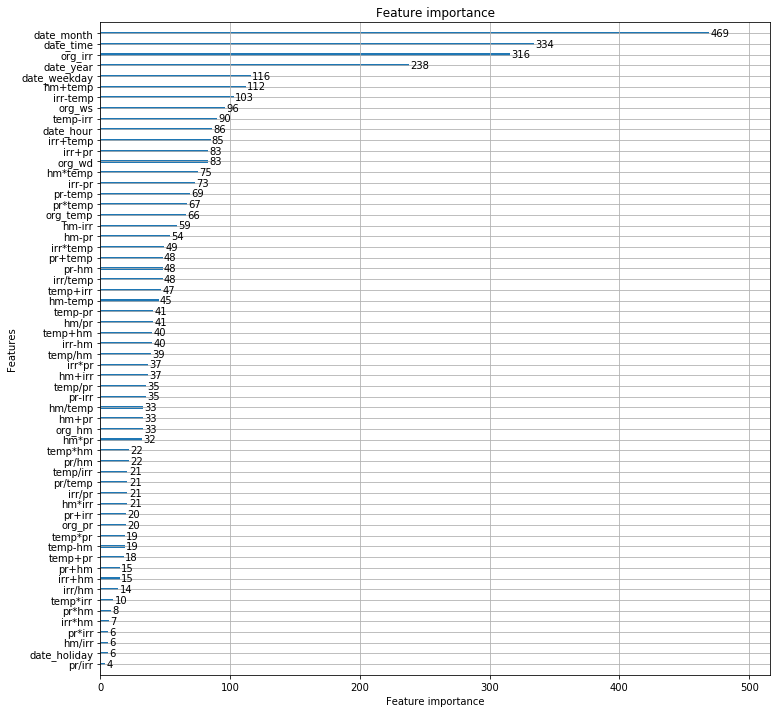

In [237]:
data = load_dataset(1)
train = data.id.isnull()
test = data.power.isnull()

X = []
train_y = data[train].power.values
feature_name = []
feature_category = []

X_date, date_name, date_cate = date_feature(data)
X_org, org_name, org_cate = origin_feature(data)
X_map, map_name, map_cate = arithmetic_field_mapping(['hm', 'irr', 'pr', 'temp'], ['hm', 'irr', 'pr', 'temp'], data)

X = np.concatenate([X_date, X_org, X_map], axis=1)
feature_name = date_name + org_name + map_name
feature_category = date_cate + org_cate + map_cate

train_X = X[train]

param = {'bagging_fraction': 0.7, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'learning_rate': 0.05, 'n_iter': 125, 'num_leaves': 31, 'objective': 'regression_l1', 'task': 'train'}
trainset = lgb.Dataset(train_X, label=train_y, feature_name=feature_name)
model = lgb.train(param, trainset, 
                  categorical_feature=np.where(np.array(feature_category)=='cat')[0].tolist(),)
lgb.plot_importance(model, figsize=(12,12))
print(np.mean(lgb_cv(param, train_X, train_y, k=5, metric=lambda x,y: score2(x, y, 1))))

loading plant 2 data
0.132215613142


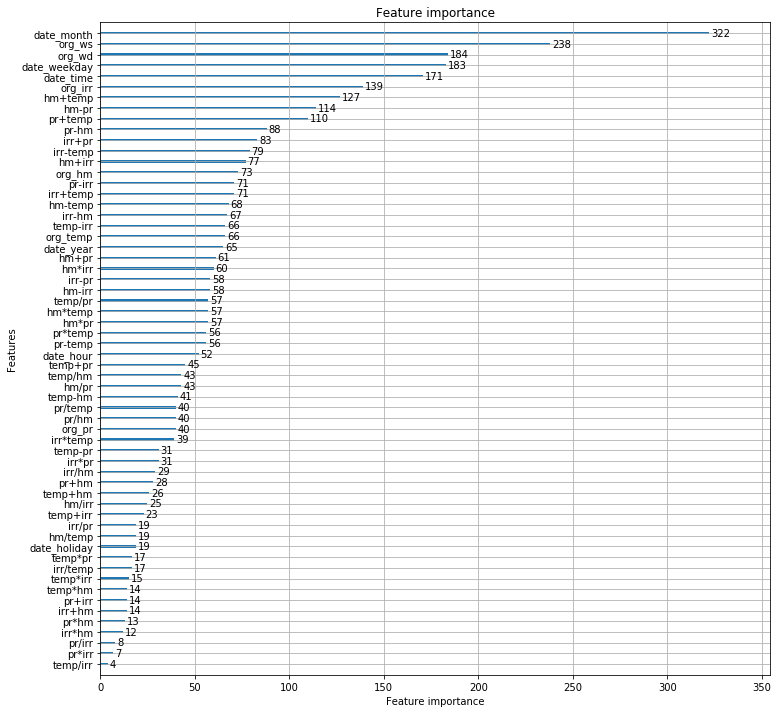

In [238]:
data = load_dataset(2)
train = data.id.isnull()
test = data.power.isnull()

X = []
train_y = data[train].power.values
feature_name = []
feature_category = []

X_date, date_name, date_cate = date_feature(data)
X_org, org_name, org_cate = origin_feature(data)
X_map, map_name, map_cate = arithmetic_field_mapping(['hm', 'irr', 'pr', 'temp'], ['hm', 'irr', 'pr', 'temp'], data)

X = np.concatenate([X_date, X_org, X_map], axis=1)
feature_name = date_name + org_name + map_name
feature_category = date_cate + org_cate + map_cate

train_X = X[train]

param = {'bagging_fraction': 0.7, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'learning_rate': 0.05, 'n_iter': 125, 'num_leaves': 31, 'objective': 'regression_l1', 'task': 'train'}
trainset = lgb.Dataset(train_X, label=train_y, feature_name=feature_name)
model = lgb.train(param, trainset, 
                  categorical_feature=np.where(np.array(feature_category)=='cat')[0].tolist(),)
lgb.plot_importance(model, figsize=(12,12))
print(np.mean(lgb_cv(param, train_X, train_y, k=5, metric=lambda x,y: score2(x, y, 1))))

loading plant 3 data
0.122731077738


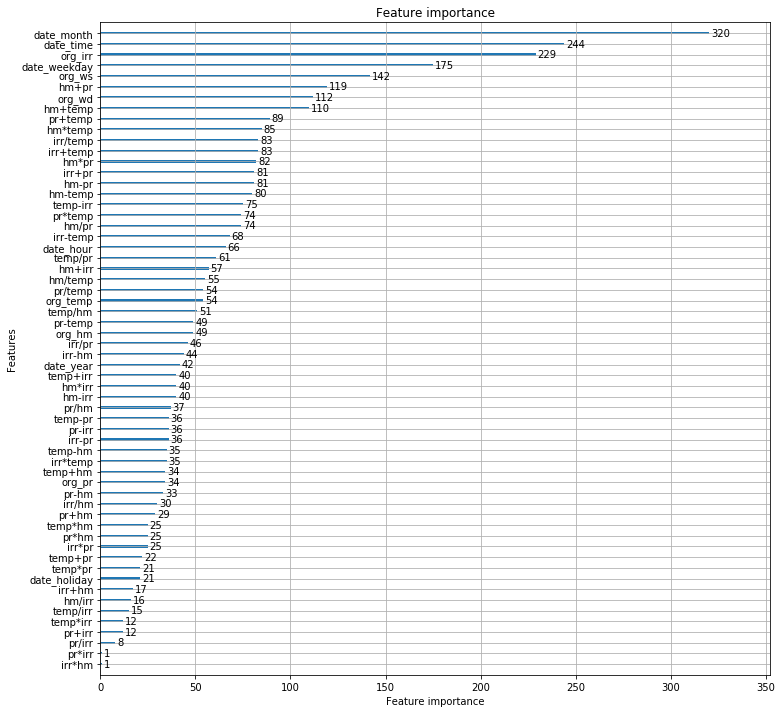

In [240]:
data = load_dataset(3)
train = data.id.isnull()
test = data.power.isnull()

X = []
train_y = data[train].power.values
feature_name = []
feature_category = []

X_date, date_name, date_cate = date_feature(data)
X_org, org_name, org_cate = origin_feature(data)
X_map, map_name, map_cate = arithmetic_field_mapping(['hm', 'irr', 'pr', 'temp'], ['hm', 'irr', 'pr', 'temp'], data)

X = np.concatenate([X_date, X_org, X_map], axis=1)
feature_name = date_name + org_name + map_name
feature_category = date_cate + org_cate + map_cate

train_X = X[train]

param = {'bagging_fraction': 0.7, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'learning_rate': 0.05, 'n_iter': 125, 'num_leaves': 31, 'objective': 'regression_l1', 'task': 'train'}
trainset = lgb.Dataset(train_X, label=train_y, feature_name=feature_name)
model = lgb.train(param, trainset, 
                  categorical_feature=np.where(np.array(feature_category)=='cat')[0].tolist(),)
lgb.plot_importance(model, figsize=(12,12))
print(np.mean(lgb_cv(param, train_X, train_y, k=5, metric=lambda x,y: score2(x, y, 3))))

loading plant 4 data
0.12265546227


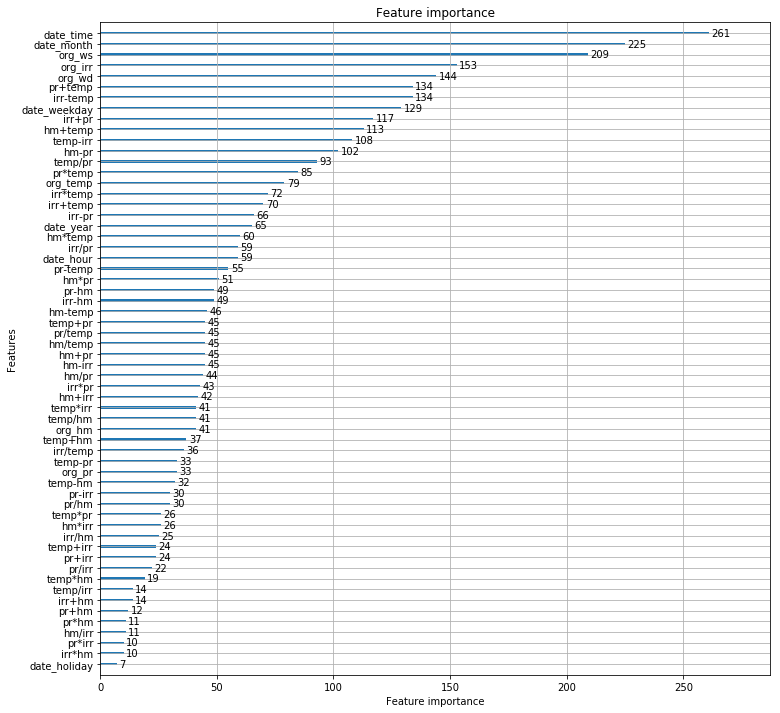

In [259]:
data = load_dataset(4)
train = data.id.isnull()
test = data.power.isnull()

X = []
train_y = data[train].power.values
feature_name = []
feature_category = []

X_date, date_name, date_cate = date_feature(data)
X_org, org_name, org_cate = origin_feature(data)
X_map, map_name, map_cate = arithmetic_field_mapping(['hm', 'irr', 'pr', 'temp'], ['hm', 'irr', 'pr', 'temp'], data)

X = np.concatenate([X_date, X_org, X_map], axis=1)
feature_name = date_name + org_name + map_name
feature_category = date_cate + org_cate + map_cate

train_X = X[train]

param = {'bagging_fraction': 0.7, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'learning_rate': 0.05,
         'n_iter': 125, 'num_leaves': 31, 'objective': 'regression_l1', 'task': 'train'}
trainset = lgb.Dataset(train_X, label=train_y, feature_name=feature_name)
model = lgb.train(param, trainset, 
                  categorical_feature=np.where(np.array(feature_category)=='cat')[0].tolist)
lgb.plot_importance(model, figsize=(12,12))
feature_mask = np.where(np.argsort(-model.feature_importance())<=40)[0]
print(np.mean(lgb_cv(param, train_X[:, feature_mask], train_y, k=5, metric=lambda x,y: score2(x, y, 4))))

In [252]:
feature_mask

(array([ 0,  1,  2,  3,  4,  7,  8,  9, 11, 14, 17, 18, 19, 20, 23, 25, 26,
        29, 30, 31, 32, 33, 34, 37, 41, 45, 47, 52, 56, 58, 59]),)

In [250]:
feature_mask = np.where(np.argsort(-model.feature_importance())<=30)

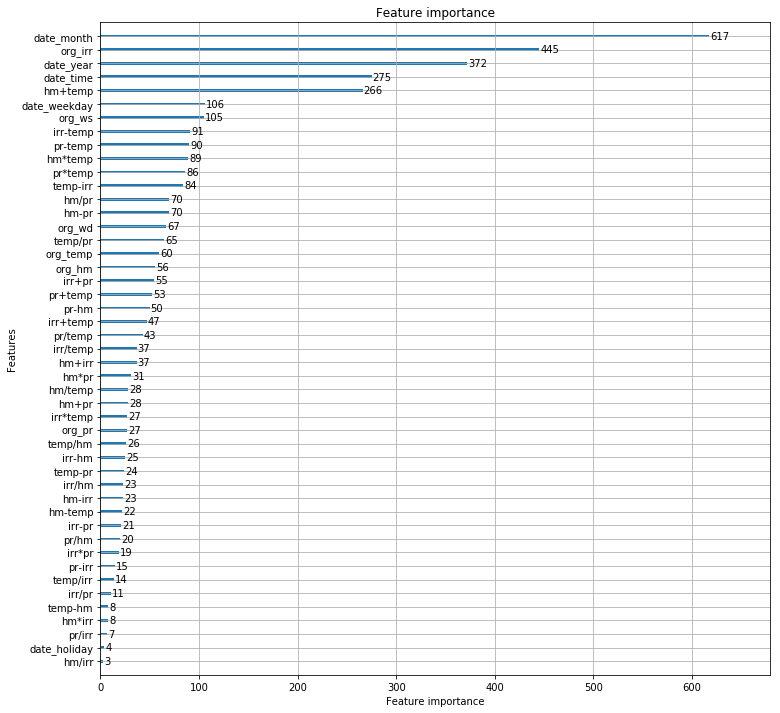

In [234]:
lgb.plot_importance(model, figsize=(12,12))

loading plant 1 data
0.116149805925


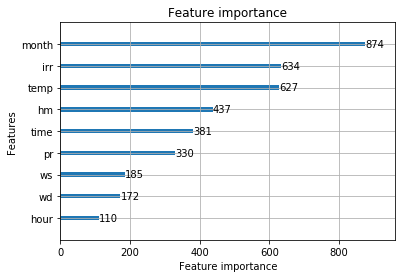

In [63]:
data = load_dataset(1)
train = data.id.isnull()
test = data.power.isnull()
data['month'] = data['time'].dt.month
data['hour'] = data['time'].dt.hour
data['time'] = LabelEncoder().fit_transform(data['time'].dt.time)

feature = ['hm', 'pr', 'temp', 'wd', 'ws', 'irr', 'month', 'hour', 'time']
train_x = data.loc[train, feature].values
train_y = data.loc[train, 'power'].values

param = {'bagging_fraction': 0.7, 'boosting': 'gbdt', 'feature_fraction': 1.0, 'learning_rate': 0.05, 'n_iter': 125, 'num_leaves': 31, 'objective': 'regression_l1', 'task': 'train'}
trainset = lgb.Dataset(data.loc[train, feature],
                           label=data[train]['power'])

model = lgb.train(param, trainset)
lgb.plot_importance(model)
print(np.mean(lgb_cv(param, train_x, train_y, k=5, metric=lambda x,y: score2(x, y, 1))))

loading plant 1 data
0.116100024666


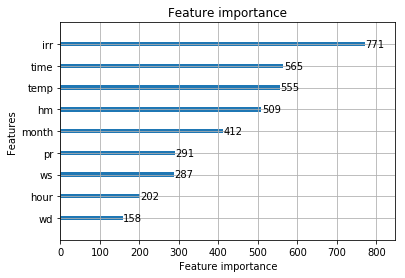

In [64]:
data = load_dataset(1)
train = data.id.isnull()
test = data.power.isnull()
data['month'] = data['time'].dt.month
data['hour'] = data['time'].dt.hour
data['time'] = LabelEncoder().fit_transform(data['time'].dt.time)
data['wd'] = LabelEncoder().fit_transform(pd.cut(data['wd'], range(0, 390, 30)).astype(str))

feature = ['hm', 'pr', 'temp', 'wd', 'ws', 'irr', 'month', 'hour', 'time']
train_x = data.loc[train, feature].values
train_y = data.loc[train, 'power'].values

param = {'bagging_fraction': 0.7, 'boosting': 'gbdt', 'feature_fraction': 1.0, 'learning_rate': 0.05, 'n_iter': 125, 'num_leaves': 31, 'objective': 'regression_l1', 'task': 'train'}

weight = np.ones_like(train_y)
weight[train_y>0.3] = 5.
trainset = lgb.Dataset(data.loc[train, feature],
                           label=data[train]['power'], weight=weight)

model = lgb.train(param, trainset)
lgb.plot_importance(model)
print(np.mean(lgb_cv(param, train_x, train_y, k=5, metric=lambda x,y: score2(x, y, 1))))

loading plant 1 data
0.116149805925


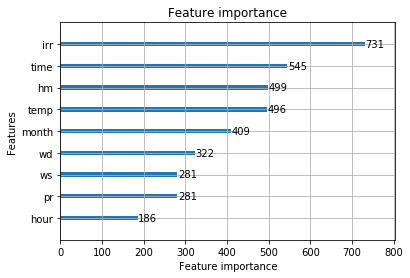

In [66]:
data = load_dataset(1)
train = data.id.isnull()
test = data.power.isnull()
data['month'] = data['time'].dt.month
data['hour'] = data['time'].dt.hour
data['time'] = LabelEncoder().fit_transform(data['time'].dt.time)
# data['temp_lag1'] = data['temp'] - data['temp'].shift(1)

feature = ['hm', 'pr', 'temp', 'wd', 'ws', 'irr', 'month', 'hour', 'time', 'temp_lag1']
train_x = data.loc[train, feature].values
train_y = data.loc[train, 'power'].values

param = {'bagging_fraction': 0.7, 'boosting': 'gbdt', 'feature_fraction': 1.0, 'learning_rate': 0.05, 'n_iter': 125, 'num_leaves': 31, 'objective': 'regression_l1', 'task': 'train'}

weight = np.ones_like(train_y)
weight[train_y>0.3] = 5.
trainset = lgb.Dataset(data.loc[train, feature],
                           label=data[train]['power'], weight=weight)

model = lgb.train(param, trainset)
lgb.plot_importance(model)
print(np.mean(lgb_cv(param, train_x, train_y, k=5, metric=lambda x,y: score2(x, y, 1))))

loading plant 1 data
0.115984352432


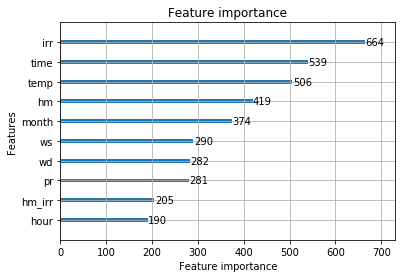

In [106]:
data = load_dataset(1)
train = data.id.isnull()
test = data.power.isnull()
data['month'] = data['time'].dt.month
data['hour'] = data['time'].dt.hour
data['time'] = LabelEncoder().fit_transform(data['time'].dt.time)
# data['irr_lag1'] = data['irr'] - data['irr'].shift(2)
data['hm_irr'] = data['hm'] * data['irr']

# irr_feature = []
# for i in range(1, 6):
#     data[f'irr_log{i}'] = data['irr'] - data['irr'].shift(i)
#     irr_feature.append(f'irr_log{i}')

feature = ['hm', 'pr', 'temp', 'wd', 'ws', 'irr', 'month', 'hour', 'time', 'hm_irr']
train_x = data.loc[train, feature].values
train_y = data.loc[train, 'power'].values

param = {'bagging_fraction': 0.7, 'boosting': 'gbdt', 'feature_fraction': 1.0, 'learning_rate': 0.05, 'n_iter': 125, 'num_leaves': 31, 'objective': 'regression_l1', 'task': 'train'}

weight = np.ones_like(train_y)
weight[train_y>0.3] = 5.
trainset = lgb.Dataset(data.loc[train, feature],
                           label=data[train]['power'], weight=weight)

model = lgb.train(param, trainset)
lgb.plot_importance(model)
print(np.mean(lgb_cv(param, train_x, train_y, k=5, metric=lambda x,y: score2(x, y, 1))))

In [145]:
def arithmetic_mapping(field_1, field_2, df):
    ret = []
    features = []
    feature_cat = ['numerical'] * 4
    for act in '+-*/':
        ret.append(eval(f'df[field_1] {act} df[field_2]').values)
        features.append(f'{field_1}{act}{field_2}')
    ret = np.stack(ret, axis=1)
    return ret, features, feature_cat


def arithmetic_field_mapping(fields_1, fields_2, df):
    field_combination = [(f1, f2) for f1 in fields_1 for f2 in fields_2]
    ret, features, feature_cat = [], [], []
    for f1, f2 in field_combination:
        r, fs, fc = arithmetic_mapping(f1, f2, df)
        ret.append(r)
        features += fs
        feature_cat += fc
    return np.concatenate(ret, axis=1), features, feature_cat


In [150]:
data = load_dataset(1)
train = data.id.isnull()
test = data.power.isnull()
data['month'] = data['time'].dt.month
data['hour'] = data['time'].dt.hour
# data['time'] = LabelEncoder().fit_transform(data['time'].dt.time)

feature = ['hm', 'pr', 'temp', 'wd', 'ws', 'irr', 'month', 'hour', 'time']
train_x = data.loc[train, feature].values
train_y = data.loc[train, 'power'].values

loading plant 1 data


In [308]:
def rolling_mean(fields, windows, data):
    ret = []
    feature = []
    for field in fields:
        for w in windows:
            ret.append(data[field].rolling(window=w).min())
            feature.append(f'{field}_w{w}_mean')
    return np.stack(ret, axis=1), feature

In [309]:
x, f = rolling_mean(['hm', 'irr'], range(4, 7), data)

pd.concat([pd.DataFrame(x, columns=f), 
           data[['hm', 'irr', 'power']].reset_index(drop=True)], axis=1).corr()

,hm_w4_mean,hm_w5_mean,hm_w6_mean,irr_w4_mean,irr_w5_mean,irr_w6_mean,hm,irr,power
hm_w4_mean,1.000000,0.999463,0.998454,-0.386584,-0.390337,-0.393279,0.996999,-0.370367,-0.384052
hm_w5_mean,0.999463,1.000000,0.999464,-0.378196,-0.382233,-0.385459,0.995049,-0.361120,-0.375239
hm_w6_mean,0.998454,0.999464,1.000000,-0.369470,-0.373782,-0.377281,0.992632,-0.351563,-0.366203
irr_w4_mean,-0.386584,-0.378196,-0.369470,1.000000,0.998734,0.994928,-0.409006,0.989447,0.864355
irr_w5_mean,-0.390337,-0.382233,-0.373782,0.998734,1.000000,0.998698,-0.411829,0.981278,0.851735
irr_w6_mean,-0.393279,-0.385459,-0.377281,0.994928,0.998698,1.000000,-0.413836,0.970823,0.836953
hm,0.996999,0.995049,0.992632,-0.409006,-0.411829,-0.413836,1.000000,-0.395553,-0.408545
irr,-0.370367,-0.361120,-0.351563,0.989447,0.981278,0.970823,-0.395553,1.000000,0.888052
power,-0.384052,-0.375239,-0.366203,0.864355,0.851735,0.836953,-0.408545,0.888052,1.000000


In [297]:
def lag(fields, windows, data):
    ret = []
    feature = []
    for field in fields:
        for w in windows:
            ret.append(data[field].shift(w))
            feature.append(f'{field}_w{w}_mean')
    return np.stack(ret, axis=1), feature

In [305]:
x, f = lag(['temp'], [1,2,3, 24, 48, 96 , 192], data)
pd.concat([pd.DataFrame(x, columns=f), 
           data[['temp', 'irr', 'power']].reset_index(drop=True)], axis=1).corr()

,temp_w1_mean,temp_w2_mean,temp_w3_mean,temp_w24_mean,temp_w48_mean,temp_w96_mean,temp_w192_mean,temp,irr,power
temp_w1_mean,1.000000,0.999527,0.998261,0.847903,0.706578,0.964599,0.943670,0.999527,0.355989,0.210912
temp_w2_mean,0.999527,1.000000,0.999527,0.857389,0.707545,0.963815,0.942777,0.998261,0.336258,0.189186
temp_w3_mean,0.998261,0.999527,1.000000,0.866906,0.708981,0.962334,0.941206,0.996219,0.315371,0.166384
temp_w24_mean,0.847903,0.857389,0.866906,1.000000,0.838563,0.823301,0.803793,0.838483,-0.136991,-0.275695
temp_w48_mean,0.706578,0.707545,0.708981,0.838563,1.000000,0.706449,0.688677,0.706078,-0.089365,-0.185007
temp_w96_mean,0.964599,0.963815,0.962334,0.823301,0.706449,1.000000,0.964858,0.964672,0.340507,0.208753
temp_w192_mean,0.943670,0.942777,0.941206,0.803793,0.688677,0.964858,1.000000,0.943875,0.335379,0.201397
temp,0.999527,0.998261,0.996219,0.838483,0.706078,0.964672,0.943875,1.000000,0.374435,0.231404
irr,0.355989,0.336258,0.315371,-0.136991,-0.089365,0.340507,0.335379,0.374435,1.000000,0.888052
power,0.210912,0.189186,0.166384,-0.275695,-0.185007,0.208753,0.201397,0.231404,0.888052,1.000000


In [319]:
def lag(fields, windows, data):
    ret = []
    feature = []
    for field in fields:
        for w in windows:
            ret.append(data[field] - data[field].shift(w))
            feature.append(f'{field}_w{w}_mean')
    return np.stack(ret, axis=1), feature

In [320]:
x, f = lag(['ws'], [1,2,3, 24, 48, 96 , 192], data)
pd.concat([pd.DataFrame(x, columns=f), 
           data[['ws', 'ws', 'power']].reset_index(drop=True)], axis=1).corr()

,ws_w1_mean,ws_w2_mean,ws_w3_mean,ws_w24_mean,ws_w48_mean,ws_w96_mean,ws_w192_mean,ws,ws,power
ws_w1_mean,1.000000,0.884880,0.828687,0.255647,0.070651,0.044109,0.039547,0.048463,0.048463,0.161419
ws_w2_mean,0.884880,1.000000,0.948670,0.320948,0.106191,0.071880,0.065426,0.085681,0.085681,0.175137
ws_w3_mean,0.828687,0.948670,1.000000,0.372018,0.138940,0.097756,0.089520,0.121360,0.121360,0.177546
ws_w24_mean,0.255647,0.320948,0.372018,1.000000,0.623168,0.351310,0.331267,0.549111,0.549111,0.034323
ws_w48_mean,0.070651,0.106191,0.138940,0.623168,1.000000,0.431195,0.390818,0.684425,0.684425,-0.200625
ws_w96_mean,0.044109,0.071880,0.097756,0.351310,0.431195,1.000000,0.533495,0.590331,0.590331,-0.022677
ws_w192_mean,0.039547,0.065426,0.089520,0.331267,0.390818,0.533495,1.000000,0.629501,0.629501,-0.020710
ws,0.048463,0.085681,0.121360,0.549111,0.684425,0.590331,0.629501,1.000000,1.000000,-0.154491
ws,0.048463,0.085681,0.121360,0.549111,0.684425,0.590331,0.629501,1.000000,1.000000,-0.154491
power,0.161419,0.175137,0.177546,0.034323,-0.200625,-0.022677,-0.020710,-0.154491,-0.154491,1.000000


In [334]:
x, f = lag(['hm'], [1,2,3, 24, 48, 96 , 192], data)
pd.concat([pd.DataFrame(x, columns=f), 
           data[['hm', 'irr', 'power']].reset_index(drop=True)], axis=1).corr()

,hm_w1_mean,hm_w2_mean,hm_w3_mean,hm_w24_mean,hm_w48_mean,hm_w96_mean,hm_w192_mean,hm,irr,power
hm_w1_mean,1.000000,0.874200,0.822734,0.453990,0.066168,0.069656,0.039305,0.026234,-0.349355,-0.346427
hm_w2_mean,0.874200,1.000000,0.945692,0.541406,0.099194,0.085033,0.049705,0.045868,-0.419938,-0.412947
hm_w3_mean,0.822734,0.945692,1.000000,0.595649,0.129675,0.095287,0.057350,0.064959,-0.465230,-0.455028
hm_w24_mean,0.453990,0.541406,0.595649,1.000000,0.681624,0.202026,0.149248,0.390557,-0.819982,-0.748043
hm_w48_mean,0.066168,0.099194,0.129675,0.681624,1.000000,0.291144,0.209724,0.532532,-0.660035,-0.550930
hm_w96_mean,0.069656,0.085033,0.095287,0.202026,0.291144,1.000000,0.620784,0.309877,-0.089206,-0.066389
hm_w192_mean,0.039305,0.049705,0.057350,0.149248,0.209724,0.620784,1.000000,0.382832,-0.090254,-0.081524
hm,0.026234,0.045868,0.064959,0.390557,0.532532,0.309877,0.382832,1.000000,-0.395553,-0.408545
irr,-0.349355,-0.419938,-0.465230,-0.819982,-0.660035,-0.089206,-0.090254,-0.395553,1.000000,0.888052
power,-0.346427,-0.412947,-0.455028,-0.748043,-0.550930,-0.066389,-0.081524,-0.408545,0.888052,1.000000


In [329]:
x.shape

(56581, 7)

In [335]:
np.cov(x[0], x[1])

array([[ nan,  nan],
       [ nan,  nan]])

In [340]:
data['power_lag3'] = data['power'].shift(3)

In [341]:
data.corr()

,hm,id,irr,mirr,power,pr,temp,wd,ws,power_lag1,power_lag3
hm,1.000000,0.383508,-0.395553,-0.395719,-0.408545,0.148941,0.227418,-0.255929,-0.127398,-0.424705,-0.451151
id,0.383508,1.000000,-0.085386,NaN,NaN,0.220563,0.130753,-0.032934,0.013921,NaN,NaN
irr,-0.395553,-0.085386,1.000000,0.902128,0.888052,-0.083590,0.374435,-0.024010,-0.137135,0.891392,0.879216
mirr,-0.395719,NaN,0.902128,1.000000,0.967860,-0.006405,0.240044,0.012178,-0.163395,0.948335,0.898643
power,-0.408545,NaN,0.888052,0.967860,1.000000,-0.019105,0.231404,0.013086,-0.154491,0.978891,0.927419
pr,0.148941,0.220563,-0.083590,-0.006405,-0.019105,1.000000,-0.283109,0.215035,-0.067355,-0.041699,-0.086782
temp,0.227418,0.130753,0.374435,0.240044,0.231404,-0.283109,1.000000,-0.348099,0.056026,0.250463,0.283900
wd,-0.255929,-0.032934,-0.024010,0.012178,0.013086,0.215035,-0.348099,1.000000,0.224593,0.004332,-0.012257
ws,-0.127398,0.013921,-0.137135,-0.163395,-0.154491,-0.067355,0.056026,0.224593,1.000000,-0.138397,-0.103495
power_lag1,-0.424705,NaN,0.891392,0.948335,0.978891,-0.041699,0.250463,0.004332,-0.138397,1.000000,0.953674
